# Explain you opinion (P5)

In [1]:
!pip install bornrule

In [2]:
!pip install cupy-cuda11x

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.4/95.4 MB 6.3 MB/s eta 0:00:00


In [3]:
!pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 10.2 MB/s eta 0:00:00


In [152]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# PREPROCESSING LIBRARIES
import nltk
import re
import string
#Stopwords to remove from the text
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words("english"))
#To tokenize words
from nltk.tokenize import word_tokenize
nltk.download('punkt')
#To lematize words
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
#Expand contractions
import contractions

#Libraries for the Classifier model
from bornrule import BornClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score

#Library for syntax parsing
import spacy
from tqdm import tqdm
nlp = spacy.load('en_core_web_sm')

#Libraries for the LDA model
from gensim.corpora import Dictionary
from gensim.models import LdaModel

#Models
import gensim
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
#Metrics for clustering
from sklearn.manifold import TSNE

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Download datasets

In [7]:
!pip install kaggle

In [ ]:
#Upload the kaggle.json file with the API key
from google.colab import files
files.upload()

In [9]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [10]:
import kaggle

In [11]:
!kaggle datasets download -d jp797498e/twitter-entity-sentiment-analysis

Dataset URL: https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis
License(s): CC0-1.0
  0% 0.00/1.99M [00:00<?, ?B/s]
100% 1.99M/1.99M [00:00<00:00, 64.6MB/s]


In [12]:
!unzip '/content/twitter-entity-sentiment-analysis.zip'

Archive:  /content/twitter-entity-sentiment-analysis.zip
  inflating: twitter_training.csv    
  inflating: twitter_validation.csv  


In [13]:
columns = ['tweet_ID', 'entity', 'sentiment', 'content']
data1 = pd.read_csv('/content/twitter_training.csv', names=columns)
data2 = pd.read_csv('/content/twitter_validation.csv', names=columns)

In [14]:
data = pd.concat([data1, data2], ignore_index=True)

In [15]:
data

,tweet_ID,entity,sentiment,content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
...,...,...,...,...
75677,4891,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...
75678,4359,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
75679,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...
75680,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.


In [16]:
data['content'] = data['content'].astype(pd.StringDtype())
data['sentiment'] = data['sentiment'].astype(pd.StringDtype())
data['entity'] = data['entity'].astype(pd.StringDtype())

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75682 entries, 0 to 75681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_ID   75682 non-null  int64 
 1   entity     75682 non-null  string
 2   sentiment  75682 non-null  string
 3   content    74996 non-null  string
dtypes: int64(1), string(3)
memory usage: 2.3 MB


In [18]:
len(data)

75682

In [19]:
data = data.dropna(ignore_index=True)

In [20]:
len(data)

74996

In [21]:
data = data[data['sentiment'] != 'Irrelevant']

In [22]:
data

,tweet_ID,entity,sentiment,content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
...,...,...,...,...
74989,314,Amazon,Negative,Please explain how this is possible! How can t...
74990,9701,PlayStation5(PS5),Positive,Good on Sony. As much as I want to see the new...
74993,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...
74994,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.


In [23]:
data = data.drop_duplicates(ignore_index=True)

In [24]:
data

,tweet_ID,entity,sentiment,content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
...,...,...,...,...
59510,1373,Battlefield,Negative,I have noticed streamers I watch who are now p...
59511,10588,RedDeadRedemption(RDR),Neutral,@6th__man playing red dead redemption- “Oh sh...
59512,7516,LeagueOfLegends,Neutral,♥️ Suikoden 2 1️⃣ Alex Kidd in Miracle World 😢...
59513,5708,HomeDepot,Positive,Thank you to Matching funds Home Depot RW paym...


## Exploring the datasets

In [25]:
# Compute the categories distributions for the dataset
entities = data.groupby('entity').size().reset_index(name='count')
entities

,entity,count
0,Amazon,2082
1,ApexLegends,2117
2,AssassinsCreed,1914
3,Battlefield,1357
4,Borderlands,1983
5,CS-GO,1586
6,CallOfDuty,1665
7,CallOfDutyBlackopsColdWar,1708
8,Cyberpunk2077,1727
9,Dota2,1839


In [26]:
# Compute the sentiment distributions for the dataset
data_sentiment = data['sentiment'].value_counts()
data_sentiment

sentiment
Negative    21790
Positive    19846
Neutral     17879
Name: count, dtype: Int64

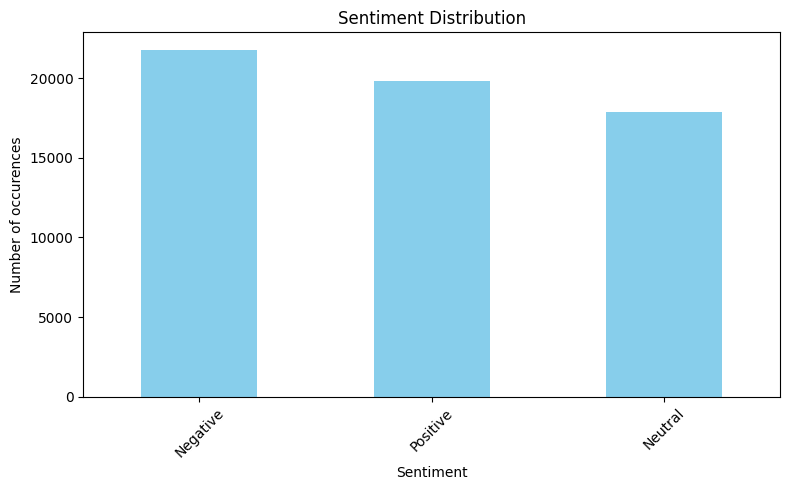

In [27]:
plt.figure(figsize=(8, 5))
data_sentiment.plot(kind='bar', color='skyblue')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of occurences')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Data pre-processing

In [270]:
MAX_WORD_LENGTH = 15

# Pre-processing functions
def remove_urls(text):
    return re.sub(r'http\S+|www\S+|https\S+', ' ', text, flags=re.MULTILINE)

def remove_mentions(text):
    return re.sub(r'@\w+', ' ', text)

def remove_hashtags(text):
    return re.sub(r'#\w+', ' ', text)

def is_text_ascii(text):
    return all(ord(char) < 128 for char in text)

def is_alpha_word(word):
    return word.isalpha()

def expand_contractions(text):
    return contractions.fix(text)

def remove_special_characters(text):
    return re.sub(r'[^a-zA-Z\s]', '', text)

def preprocess_tweet(tweet):
    tweet = remove_urls(tweet)
    tweet = remove_mentions(tweet)
    tweet = remove_hashtags(tweet)

    if not is_text_ascii(tweet):
        return ""

    tweet = tweet.lower()
    tweet = expand_contractions(tweet)
    tweet = remove_special_characters(tweet)

    tokens = word_tokenize(tweet)

    lemmatizer = WordNetLemmatizer()

    tokens = [word for word in tokens if is_alpha_word(word)]
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    tokens = [word for word in tokens if len(word) <= MAX_WORD_LENGTH]

    return ' '.join(tokens)

In [184]:
data.loc[:, "text"]= data["content"].apply(preprocess_tweet)

In [185]:
data

,tweet_ID,entity,sentiment,content,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,getting borderland murder
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,coming border kill
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,getting borderland kill
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,coming borderland murder
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,getting borderland murder
...,...,...,...,...,...
48516,201,Amazon,Neutral,Across the Fourwinds is the first book of the ...,across fourwinds first book maidstone chronicl...
48517,1264,Battlefield,Positive,I started getting back into playing Battlefiel...,started getting back playing battlefield hardl...
48518,2734,Borderlands,Positive,surprise i still love #borderlands ' jack pic....,surprise still love jack
48519,4444,Google,Neutral,This is....odd. @Google suggests the most dead...,isodd suggests deadly terrorst attack committe...


In [271]:
data["text"] = data['text'].astype(pd.StringDtype())

In [272]:
data = data[data.apply(lambda row: row.astype(str).str.strip() != '').all(axis=1)]

In [273]:
data = data.dropna(ignore_index=True)

In [274]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48484 entries, 0 to 48483
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_ID   48484 non-null  int64 
 1   entity     48484 non-null  string
 2   sentiment  48484 non-null  string
 3   content    48484 non-null  string
 4   text       48484 non-null  string
dtypes: int64(1), string(4)
memory usage: 1.8 MB


## Sentiment analysis classification with Born Classifier

Perform a sentiment analysis classification of documents using Born

In [275]:
vec = CountVectorizer(tokenizer=word_tokenize, lowercase=True, token_pattern=None)
X = vec.fit_transform(data['text'])

In [276]:
X_train, X_test, y_train, y_test = train_test_split(X, data['sentiment'], test_size=0.2, random_state=42)

In [277]:
# Initialize the BornClassifier
born_classifier = BornClassifier()

# Fit the classifier to the training data
born_classifier.fit(X_train, y_train)

BornClassifier()

In [278]:
print(X_train.shape, X_test.shape)

(38787, 25125) (9697, 25125)


In [279]:
born_predictions = born_classifier.predict(X_test)
born_accuracy = accuracy_score(y_test, born_predictions)
print(f"Born Accuracy: {born_accuracy}")

Born Accuracy: 0.7701350933278334


In [280]:
# Evaluate the classifier
print(classification_report(y_test, born_predictions))

              precision    recall  f1-score   support

    Negative       0.78      0.83      0.80      3624
     Neutral       0.77      0.63      0.70      2648
    Positive       0.76      0.81      0.78      3425

    accuracy                           0.77      9697
   macro avg       0.77      0.76      0.76      9697
weighted avg       0.77      0.77      0.77      9697



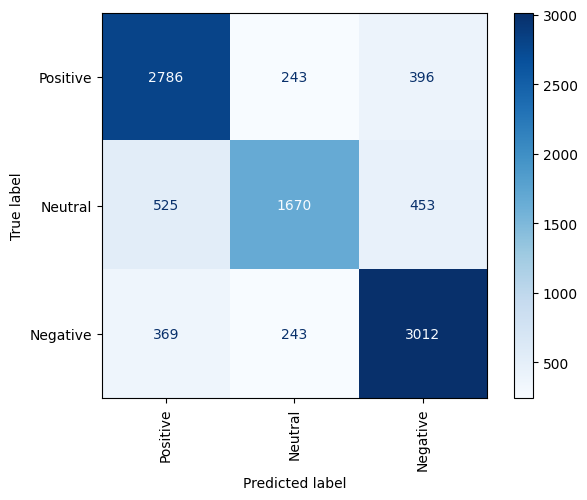

In [281]:
matrix = confusion_matrix(y_test, born_predictions, labels=data['sentiment'].unique())

fig, ax = plt.subplots(figsize=(7, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=data['sentiment'].unique())
disp.plot(ax=ax, cmap='Blues')
ax.xaxis.set_tick_params(rotation=90)

plt.show()

## Explanation features

Extract the explanation features for each pair of documents and predicted labels

In [350]:
# Get explanations from the Born Classifier
explanations = born_classifier.explain()
# Create a reverse mapping for vectorized features
feature_names = vec.get_feature_names_out()

In [351]:
sentiment = data.groupby('sentiment').size().reset_index(name='count')
sentiment

,sentiment,count
0,Negative,17949
1,Neutral,13733
2,Positive,16802


In [352]:
explanation_features = pd.DataFrame(explanations.toarray(), index=feature_names, columns=sentiment['sentiment'])
explanation_features

sentiment,Negative,Neutral,Positive
aa,0.005393,0.0,0.000000
aaa,0.001940,0.0,0.001825
aaaaaaaaaaaa,0.000000,0.0,0.000000
aaaaaaaaaaaaa,0.000000,0.0,0.005764
aaaaaaaaaaages,0.000000,0.0,0.003228
...,...,...,...
zyotflen,0.000000,0.0,0.003057
zywzswpxq,0.002519,0.0,0.000000
zzgixvkt,0.002954,0.0,0.000000
zzvfsrhewg,0.000000,0.0,0.000000


In [353]:
explanation_features.columns.name = None

In [354]:
explanation_features = explanation_features[(explanation_features['Negative'] > 0) | (explanation_features['Neutral'] > 0) | (explanation_features['Positive'] > 0)]
len(explanation_features)

23220

In [355]:
threshold_neutral = np.percentile(explanation_features['Neutral'], 75)
threshold_negative = np.percentile(explanation_features['Negative'], 75)
threshold_positive = np.percentile(explanation_features['Positive'], 75)

In [356]:
explanation_features = explanation_features[ (explanation_features['Neutral'] >= threshold_neutral) | (explanation_features['Negative'] >= threshold_negative) | (explanation_features['Positive'] >= threshold_positive)]

In [357]:
explanation_features['Positive'].sort_values(ascending=False).head(15)

love           0.045272
nice           0.036762
dope           0.034753
wait           0.033610
wow            0.032039
excited        0.031424
beautiful      0.031225
thank          0.029501
fun            0.026972
tuning         0.025954
best           0.022909
interesting    0.022270
amazing        0.022158
awesome        0.021108
good           0.020539
Name: Positive, dtype: float64

In [358]:
explanation_features['Negative'].sort_values(ascending=False).head(15)

fix            0.055147
fuck           0.045117
server         0.033072
suck           0.029313
trash          0.025499
shit           0.024376
broken         0.023800
glitch         0.022910
wtf            0.022536
eamaddennfl    0.021766
disrespect     0.021599
unplayable     0.021439
hate           0.019730
ugly           0.019697
crashing       0.019357
Name: Negative, dtype: float64

In [359]:
explanation_features['Neutral'].sort_values(ascending=False).head(15)

earned         0.047620
check          0.036934
achievement    0.027884
horrific       0.025187
vision         0.023123
beep           0.021935
love           0.021684
summoners      0.020597
hulk           0.019465
orgrimmar      0.019372
panic          0.019094
godrays        0.018996
managing       0.017867
video          0.017532
yu             0.017138
Name: Neutral, dtype: float64

In [360]:
features = explanation_features.reset_index()

In [361]:
features.rename(columns={'index': 'word'}, inplace=True)

In [362]:
features['word'] = features['word'].astype(pd.StringDtype())

In [363]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16021 entries, 0 to 16020
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   word      16021 non-null  string 
 1   Negative  16021 non-null  float64
 2   Neutral   16021 non-null  float64
 3   Positive  16021 non-null  float64
dtypes: float64(3), string(1)
memory usage: 500.8 KB


In [364]:
list_feature = list(features.word)

## 1. Computing the candidate aspects: Syntax Based approach

In [410]:
def extract_aspects_and_sentences(text):
    doc = nlp(text)
    aspect_sentences = set()
    processed_aspects = set()

    for sent in doc.sents:
        for token in sent:
            aspect = None
            aspect_segment = []
            if token.dep_ == 'amod' and token.head.pos_ == 'NOUN':
                aspect = token.head.text
                aspect_segment.append(token.head)
                aspect_segment.append(token)
            elif token.dep_ == 'nsubj' and token.head.pos_ == 'VERB':
                aspect = token.text
                aspect_segment.append(token)
                for child in token.head.children:
                    if child.dep_ == 'dobj':
                        aspect_segment.append(child)

            if aspect:
                aspect_start = min([t.idx for t in aspect_segment])
                aspect_end = max([t.idx + len(t.text) for t in aspect_segment])
                aspect_sentence = sent.text[aspect_start:aspect_end].strip()

                if aspect not in processed_aspects:
                    aspect_sentences.add((aspect, aspect_sentence))
                    processed_aspects.add(aspect)

    return list(aspect_sentences)

In [411]:
aspect_sentences = extract_aspects_and_sentences(data['text'][565])
aspect_sentences[:3]

[('system', 'whole factory reset system'), ('fix', 'big hot fix')]

In [412]:
aspect_df = []

for i, row in tqdm(data.iterrows(), total=data.shape[0]):
    tweet_id = row['tweet_ID']
    entity = row['entity']
    sentiment = row['sentiment']
    text = row['text']

    aspect_sentences = extract_aspects_and_sentences(text)

    for aspect, sentence in aspect_sentences:
        if aspect in list_feature:
            aspect_df.append((tweet_id, entity, aspect, sentence, sentiment))

aspect_data = pd.DataFrame(aspect_df, columns=['id', 'entity', 'aspect', 'sentence', 'sentiment'])

100%|██████████| 48484/48484 [08:38<00:00, 93.49it/s]


In [413]:
aspect_data

,id,entity,aspect,sentence,sentiment
0,2401,Borderlands,kill,coming border kill,Positive
1,2401,Borderlands,borderland,borderland,Positive
2,2402,Borderlands,fun,fun know huge fan maya,Positive
3,2402,Borderlands,fun,fun,Positive
4,2402,Borderlands,fun,fun,Positive
...,...,...,...,...,...
39737,9672,PlayStation5(PS5),girl,beautiful girl,Positive
39738,1264,Battlefield,game,different game,Positive
39739,4444,Google,usaaf,usaaf,Neutral
39740,4444,Google,isodd,isodd,Neutral


In [414]:
aspect_data = aspect_data.drop_duplicates(ignore_index=True)
aspect_data

,id,entity,aspect,sentence,sentiment
0,2401,Borderlands,kill,coming border kill,Positive
1,2401,Borderlands,borderland,borderland,Positive
2,2402,Borderlands,fun,fun know huge fan maya,Positive
3,2402,Borderlands,fun,fun,Positive
4,2403,Borderlands,varlope,la varlope,Neutral
...,...,...,...,...,...
27254,10889,TomClancysGhostRecon,month,next month,Negative
27255,10889,TomClancysGhostRecon,update,immersive update,Negative
27256,11363,TomClancysRainbowSix,fortress,chalet fortress,Positive
27257,452,ApexLegends,getting,comic getting,Positive


In [415]:
aspect_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27259 entries, 0 to 27258
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         27259 non-null  int64 
 1   entity     27259 non-null  object
 2   aspect     27259 non-null  object
 3   sentence   27259 non-null  object
 4   sentiment  27259 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.0+ MB


In [ ]:
aspect_data['sentiment'], aspect_data['sentence'] = aspect_data['sentiment'].astype(pd.StringDtype()),aspect_data['sentence'].astype(pd.StringDtype())

In [426]:
a = aspect_data.groupby(['entity','aspect']).size().reset_index(name='count')

In [427]:
a = a[ (a['count'] >= np.percentile(a['count'], 75))]

In [435]:
a.sort_values(by='count', ascending=False).head(15)

,entity,aspect,count
10645,johnson&johnson,johnson,295
8502,RedDeadRedemption(RDR),redemption,263
9,Amazon,amazon,188
1308,Borderlands,borderland,153
9133,TomClancysRainbowSix,game,149
8353,RedDeadRedemption(RDR),game,143
3598,Facebook,facebook,136
6009,MaddenNFL,eamaddennfl,131
8740,TomClancysGhostRecon,game,118
3283,FIFA,fifa,118


#### Predict the sentiment

Predict the sentiment for the sentence or text portion using the trained Born classifier

In [417]:
X = vec.transform(aspect_data['sentence'])

In [418]:
X_train, X_test, y_train, y_test = train_test_split(X, aspect_data['sentiment'], test_size=0.2, random_state=42)

In [419]:
print(X_train.shape, X_test.shape)

(21807, 25125) (5452, 25125)


In [420]:
born_predictions = born_classifier.predict(X_test)
born_accuracy = accuracy_score(y_test, born_predictions)
print(f"Born Accuracy: {born_accuracy}")

Born Accuracy: 0.7118488628026413


In [421]:
# Evaluate the classifier
print(classification_report(y_test, born_predictions))

              precision    recall  f1-score   support

    Negative       0.74      0.77      0.75      2061
     Neutral       0.70      0.67      0.68      1767
    Positive       0.69      0.68      0.69      1624

    accuracy                           0.71      5452
   macro avg       0.71      0.71      0.71      5452
weighted avg       0.71      0.71      0.71      5452



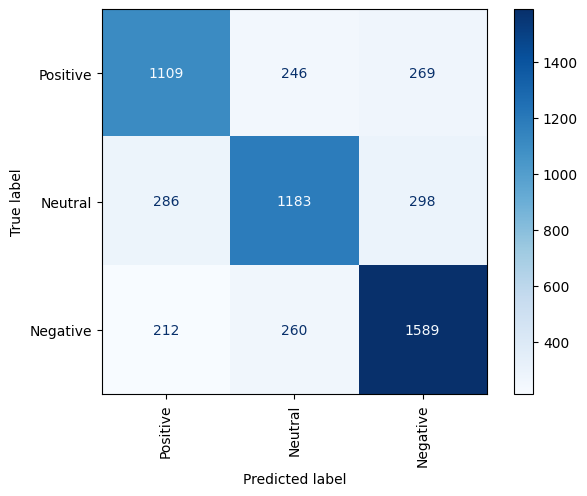

In [422]:
matrix = confusion_matrix(y_test, born_predictions, labels=data['sentiment'].unique())

fig, ax = plt.subplots(figsize=(7, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=data['sentiment'].unique())
disp.plot(ax=ax, cmap='Blues')
ax.xaxis.set_tick_params(rotation=90)

plt.show()

## 2. Computing the candidate aspects LDA model approach

In [258]:
# Preprocess function to tokenized
def preprocess(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop and not token.is_punct and token.lemma_ not in stop_words and token.pos_ == 'NOUN']
    return tokens

In [436]:
sentence = pd.DataFrame(data)

In [437]:
dic = features['word'].apply(preprocess)
sentence['token'] = sentence['content'].apply(preprocess)

In [438]:
#Create the dictionary and the corpus
dictionary = Dictionary(dic)
corpus = [dictionary.doc2bow(text) for text in sentence['token']]

In [439]:
#Fit the LDA model
num_topics = 32  # Number of categories
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10)

In [440]:
# Function to assign topics to documents
def get_document_topics(text):
    bow = dictionary.doc2bow(text)
    topics = lda_model.get_document_topics(bow)
    return topics

In [441]:
sentence['topics'] = sentence['token'].apply(get_document_topics)

In [442]:
# Extract sentences and associate them to the topics
def extract_aspects_and_sentences(row):
    text = row['text']
    doc = nlp(text)
    topics = lda_model.get_document_topics(dictionary.doc2bow(row['token']), minimum_probability=0.1)
    aspect_sentences = defaultdict(list)

    for topic_id, prob in topics:
        aspect = lda_model.show_topic(topic_id, topn=1)[0][0]

    for sent in doc.sents:
        sent_text = sent.text.strip()
        for topic_id, prob in topics:
            aspect = lda_model.show_topic(topic_id, topn=1)[0][0]
            if aspect in sent_text and all(aspect not in s for s in aspect_sentences[aspect]):
                aspect_sentences[aspect].append(sent_text)

    result = []
    for aspect, sentences in aspect_sentences.items():
        if sentences:
            for sentence in sentences:
                result.append((row['tweet_ID'], row['entity'], aspect, sentence, row['sentiment']))

    return result

In [443]:
aspect_df = []

for i, row in tqdm(sentence.iterrows(), total=sentence.shape[0]):
    aspect_df.extend(extract_aspects_and_sentences(row))

aspect_data = pd.DataFrame(aspect_df, columns=['id', 'entity', 'aspect', 'sentence', 'sentiment'])

100%|██████████| 48484/48484 [08:53<00:00, 90.93it/s]


In [444]:
aspect_data = aspect_data.drop_duplicates(ignore_index=True)
aspect_data

,id,entity,aspect,sentence,sentiment
0,2402,Borderlands,pc,spent hour making something fun know huge fan ...,Positive
1,2402,Borderlands,pc,spent couple hour something fun know huge bord...,Positive
2,2402,Borderlands,pc,spent hour making something fun know huge rhan...,Positive
3,2404,Borderlands,time,first borderland session long time actually re...,Positive
4,2404,Borderlands,time,first borderland session long time actually re...,Positive
...,...,...,...,...,...
18525,3645,Cyberpunk2077,night,good morning hot gross last night ended pullin...,Positive
18526,7365,LeagueOfLegends,video,check video captured,Neutral
18527,7382,LeagueOfLegends,video,check video captured,Neutral
18528,7617,MaddenNFL,game,make cross play thing next madden also gift se...,Negative


In [445]:
aspect_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18530 entries, 0 to 18529
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         18530 non-null  int64 
 1   entity     18530 non-null  object
 2   aspect     18530 non-null  object
 3   sentence   18530 non-null  object
 4   sentiment  18530 non-null  object
dtypes: int64(1), object(4)
memory usage: 724.0+ KB


In [446]:
aspect_data['sentiment'], aspect_data['sentence'] = aspect_data['sentiment'].astype(pd.StringDtype()),aspect_data['sentence'].astype(pd.StringDtype())

In [455]:
a = aspect_data.groupby(['aspect']).size().reset_index(name='count')

In [456]:
a.sort_values(by='count', ascending=False).head(15)

,aspect,count
8,game,5494
26,time,2163
31,year,1354
18,player,865
30,video,839
25,thank,829
19,problem,622
7,fuck,564
12,lot,502
13,man,498


### Predict the sentiment

Predict the sentiment for the sentence or text portion using the trained Born classifier

In [375]:
X = vec.transform(aspect_data['sentence'])

In [376]:
X_train, X_test, y_train, y_test = train_test_split(X, aspect_data['sentiment'], test_size=0.2, random_state=42)

In [377]:
print(X_train.shape, X_test.shape)

(15751, 25125) (3938, 25125)


In [378]:
born_predictions = born_classifier.predict(X_test)
born_accuracy = accuracy_score(y_test, born_predictions)
print(f"Born Accuracy: {born_accuracy}")

Born Accuracy: 0.7783138649060437


In [379]:
# Evaluate the classifier
print(classification_report(y_test, born_predictions))

              precision    recall  f1-score   support

    Negative       0.81      0.85      0.83      1620
     Neutral       0.71      0.55      0.62       925
    Positive       0.77      0.84      0.81      1393

    accuracy                           0.78      3938
   macro avg       0.76      0.75      0.75      3938
weighted avg       0.77      0.78      0.77      3938



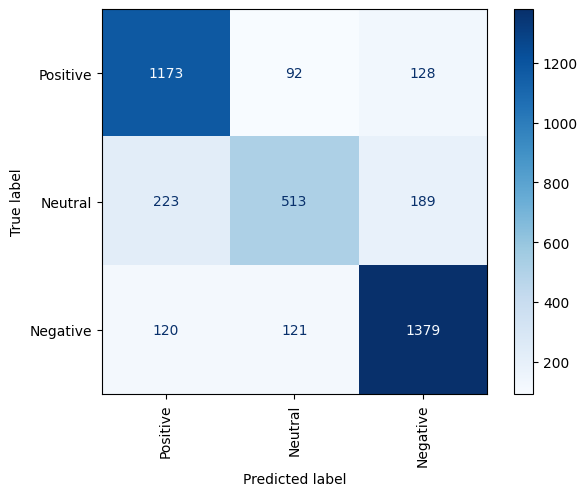

In [380]:
matrix = confusion_matrix(y_test, born_predictions, labels=data['sentiment'].unique())

fig, ax = plt.subplots(figsize=(7, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=data['sentiment'].unique())
disp.plot(ax=ax, cmap='Blues')
ax.xaxis.set_tick_params(rotation=90)

plt.show()

## 3. Computing the candidate aspects Hybrid model approach

In [457]:
# Tokenized documents
tokenized_docs = [preprocess(doc) for doc in data['content']]

Word2Vec model

In [458]:
# Fit Word2Vec model
model = Word2Vec(sentences=tokenized_docs, vector_size=100, window=5, min_count=1, workers=4)

feature_vectors = [model.wv[feature] for feature in list_feature if feature in model.wv]

K-means

In [ ]:
# KMeans
num_clusters = 32
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
kmeans.fit(feature_vectors)

# Clusters with words
clusters = {i: [] for i in range(num_clusters)}
for i, label in enumerate(kmeans.labels_):
    clusters[label].append(list_feature[i])

In [460]:
for cluster_id, features in clusters.items():
    print(f"Cluster {cluster_id}: {features}")

Cluster 0: ['aa', 'aaaaaaaaaaages', 'aaarated', 'aarogya', 'aaronrodgers', 'abandon', 'abnormal', 'aboard', 'absently', 'abuse', 'abusing', 'accelerated', 'accepting', 'acclaimmag', 'acclimatization', 'accomplish', 'according', 'account', 'accountability', 'accountant', 'accountmy', 'accuses', 'accusing', 'acedfallcom', 'achieve', 'achievementland', 'achieving', 'aching', 'acne', 'acolitis', 'acolyte', 'acquires', 'actictical', 'actiongef', 'activism', 'actuallys', 'additionnow', 'adeolafayehun', 'adler', 'admiring', 'adopter', 'adsense', 'adsunk', 'advertisement', 'advisor', 'adweekcom', 'aecafrica', 'aero', 'afb', 'affording', 'afghanistan', 'afkgamingcom', 'afr', 'africanbattler', 'afunk', 'afvision', 'afx', 'againbebvcgstgo', 'aggressive', 'aging', 'agoi', 'agothey', 'agree', 'ahhhh', 'ahirunhs', 'ahyjfemso', 'aijbchy', 'aime', 'aiunk', 'ajdb', 'ajipdrkm', 'akali', 'akin', 'ako', 'akpujrrud', 'alan', 'albatross', 'albertsons', 'aldzjwades', 'alexander', 'alexeilavjoy', 'alienated',

In [461]:
# Dimensionality reduction using t-SNE
tsne = TSNE(n_components=2, perplexity=50, n_iter=300)
tsne_result = tsne.fit_transform(np.array(feature_vectors))

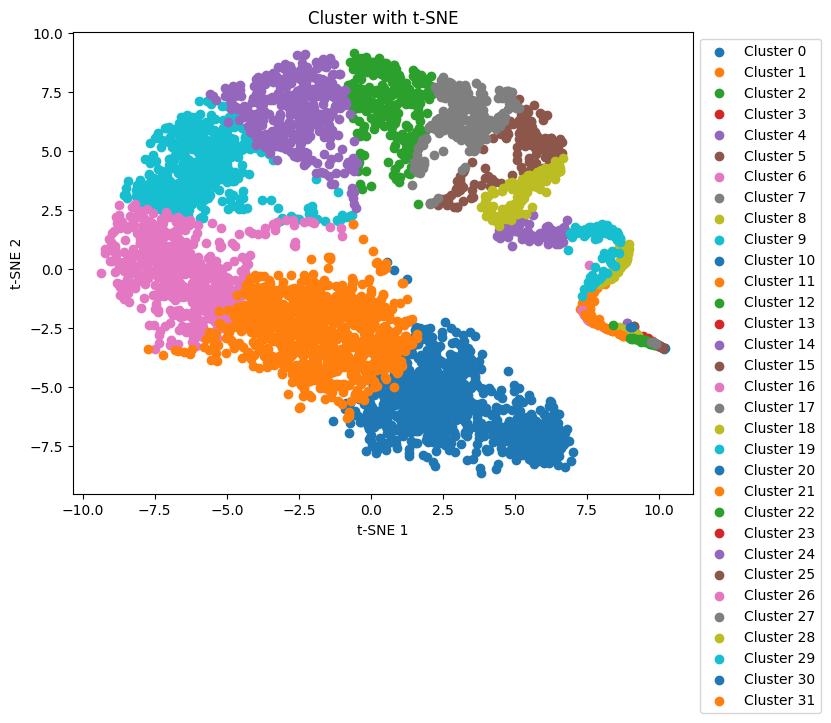

In [462]:
plt.figure(figsize=(8, 6))
for i in range(num_clusters):
    points = tsne_result[np.where(kmeans.labels_ == i)]
    plt.scatter(points[:, 0], points[:, 1], label=f'Cluster {i}')
plt.title('Cluster with t-SNE')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

 Associate each aspect to a specific sentence or portion of the text

In [463]:
def extract_aspects(text, aspects):
    doc = nlp(text)
    aspect_sentences = {aspect: [] for aspect in aspects}

    for sent in doc.sents:
        for aspect_id, aspect in aspects:
            if aspect in sent.text:
                # Dependency parsing to find the syntactic relation between aspect and sentence
                for token in sent:
                    if token.text == aspect:
                        subtree_span = doc[token.left_edge.i : token.right_edge.i + 1]
                        aspect_sentence = subtree_span.text
                        aspect_sentences[(aspect_id, aspect)].append(aspect_sentence)

    return aspect_sentences

In [464]:
aspect_df = []

for i, row in tqdm(data.iterrows(), total=data.shape[0]):
    id = row['tweet_ID']
    entity = row['entity']
    sentiment = row['sentiment']
    text = row['text']

    aspects = [(id, feature) for (id, cluster) in clusters.items() for feature in cluster]
    aspect_sentences = extract_aspects(text, aspects)

    for (id_aspect, aspect), sentences in aspect_sentences.items():
        if sentences:
            for sentence in sentences:
                aspect_df.append((id, entity, aspect, sentence, sentiment, id_aspect ))

aspect_data = pd.DataFrame(aspect_df, columns=['id', 'entity', 'aspect', 'sentence', 'sentiment', 'cluster'])

100%|██████████| 48484/48484 [45:12<00:00, 17.87it/s]


In [465]:
aspect_data = aspect_data.drop_duplicates(ignore_index=True)
aspect_data

,id,entity,aspect,sentence,sentiment,cluster
0,2401,Borderlands,borderland,borderland,Positive,9
1,2401,Borderlands,coming,coming,Positive,18
2,2402,Borderlands,favorite,favorite,Positive,8
3,2402,Borderlands,enjoy,enjoy,Positive,25
4,2402,Borderlands,borderland,borderland,Positive,9
...,...,...,...,...,...,...
40771,11869,Verizon,cellular,cellular,Neutral,0
40772,11869,Verizon,certified,certified,Neutral,0
40773,11869,Verizon,collect,collect usage power quality data,Neutral,0
40774,201,Amazon,amazon,journey amazon,Neutral,26


In [466]:
aspect_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40776 entries, 0 to 40775
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         40776 non-null  int64 
 1   entity     40776 non-null  object
 2   aspect     40776 non-null  object
 3   sentence   40776 non-null  object
 4   sentiment  40776 non-null  object
 5   cluster    40776 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [467]:
aspect_data['sentiment'], aspect_data['sentence'] = aspect_data['sentiment'].astype(pd.StringDtype()),aspect_data['sentence'].astype(pd.StringDtype())

In [468]:
a = aspect_data.groupby(['entity','aspect']).size().reset_index(name='count')

In [469]:
a = a[ (a['count'] >= np.percentile(a['count'], 75))]

In [470]:
a.sort_values(by='count', ascending=False).head(15)

,entity,aspect,count
1695,Borderlands,borderland,564
4366,Facebook,facebook,542
41,Amazon,amazon,505
2199,CS-GO,csgo,423
1353,Battlefield,battlefield,388
1141,AssassinsCreed,creed,333
9620,RedDeadRedemption(RDR),dead,332
7053,MaddenNFL,eamaddennfl,286
995,AssassinsCreed,assassin,212
11381,WorldOfCraft,earned,200


### Predict the sentiment

Predict the sentiment for the sentence or text portion using the trained Born classifier

In [471]:
X = vec.transform(aspect_data['sentence'])

In [472]:
X_train, X_test, y_train, y_test = train_test_split(X, aspect_data['sentiment'], test_size=0.2, random_state=42)

In [473]:
print(X_train.shape, X_test.shape)

(32620, 25125) (8156, 25125)


In [474]:
born_predictions = born_classifier.predict(X_test)
born_accuracy = accuracy_score(y_test, born_predictions)
print(f"Born Accuracy: {born_accuracy}")

Born Accuracy: 0.7103972535556645


In [475]:
# Evaluate the classifier
print(classification_report(y_test, born_predictions))

              precision    recall  f1-score   support

    Negative       0.74      0.74      0.74      3080
     Neutral       0.72      0.67      0.69      2674
    Positive       0.66      0.72      0.69      2402

    accuracy                           0.71      8156
   macro avg       0.71      0.71      0.71      8156
weighted avg       0.71      0.71      0.71      8156



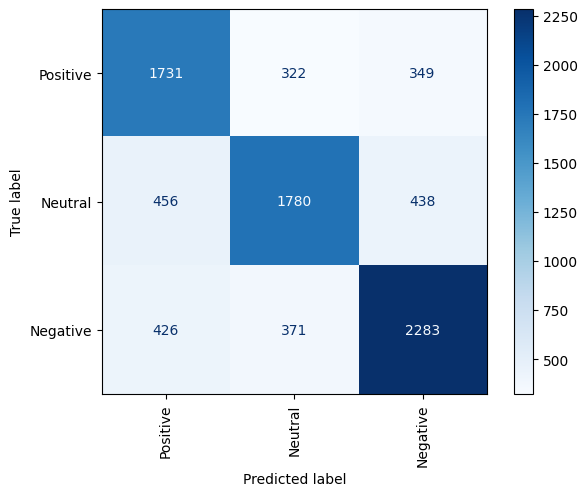

In [476]:
matrix = confusion_matrix(y_test, born_predictions, labels=data['sentiment'].unique())

fig, ax = plt.subplots(figsize=(7, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=data['sentiment'].unique())
disp.plot(ax=ax, cmap='Blues')
ax.xaxis.set_tick_params(rotation=90)

plt.show()